# How much can we learn from Deep Linear Networks?
# Re: Saxe et al. (2013 & 2019; PNAS)
# - A Mathematical Theory of  Deep Linear Networks -

We do not understand the learning dynamics underlying the optimization of highly composed non-linear functions aka Deep Neural Networks. Especially, in high dimensions it is illusive to talk about the notion of "understanding" how Stochastic Gradient Descent and Automatic Differentiation accomplish to not get stuck in local minima.

So what can we do? Start by understanding the next lower layer of complexity - **Deep Linear Networks**. And that is exaclty what the work of Andrew Saxe in the recent years has been aiming at. Linear Networks share many essential features with non-linear ones (most importantly compositionality) and their learning dynamics can as well behave highly non-linear. By establishing solid theoretical results for the linear case, we might be able to transfer some of such results as intuitions to the field of non-linear networks.

And Saxe et al. (2013) provided the first real breakthrough in terms of understanding what is actually happening throughout the different epochs of Online SGD - more specifically, why one often times observes plateus in the learning dynamics. Saxe et al. (2019) provides a more "cognitive neuroscience story" of how this might relate to semantization of concepts/knowledge.

**TL; DR:** This blog post provides a mini-reproduction of the key insights/results from the initial work by Andrew Saxe & tests how these generalize to deeper & non-linear networks. Finally, we inspect how singular value mode convergence relates to generalization & the potential of designing new regularizers with that in mind!

<font color='green'>

## Next Things To Do

* [ ] Clean code - compress functions & plots, text
* [ ] Parallelize the tree data-generation
* [ ] Add train/test split to deep net training
* [ ] Analyze/Plot how singular value modes relate to generalization
* [ ] Add early stopping criterion
* [ ] Add penalty/prior regularizer
* [ ] Write text around it
* [ ] Clean up & publish
</font>

<font color='red'>
    
## Simplistic Example Questions:
- Look at learning rate behaviour/time of convergence
- Look at larger initialization weights/variance in Gaussian
- Look at different numbers of hidden units

## Hierarchical Data Generation/Branching Diffusion Process:
- Generate random input/orthogonal matrices as input items & hierarchical features - overfitting?
- from scipy.stats import ortho_group
    x = ortho_group.rvs(3)
    x

## Deeper Networks in PyTorch Questions:
- How robust is the intuition to different hyperparameters:
    - Weight initialization robustness as function of depth
    - Effects of Batch GD / Different Optimizers
- How do singular values relate to overfitting? - Possible to write down a regularizer?
    - Write down a form of penalty/prior term. I.e. of the form $\lambda ||s - a(t)||$
    - Formulate an early stopping rule to prevent overfitting 

</font>

# A Simplistic Example in Plain NumPy

In the following we replicate figure 3c from the main paper (p. 3). This includes the simulation check of the theoretical results on the convergence of the different singular value modes for the single hidden-layer as well as the shallow network case.

Structure of the code:
* Generate the toy data from Saxe et al. 19'
* Implement the continuous time update equations
* Implement the exact equations for the singular value dynamics

In [52]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
from numpy.linalg import svd as svd
import matplotlib.pyplot as plt

from plot_helpers import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


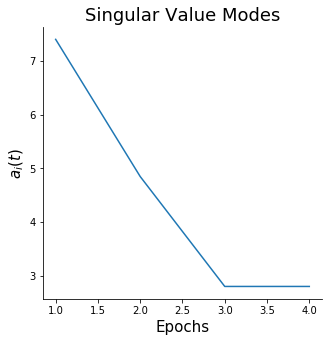

In [53]:
"""
Generate the toy data (Saxe et al. 19 - Supplementary page S3)
    - Details: 7 Features, 4 items, 16 Hidden Units
"""
SIGMA_X = X = np.diag(np.ones(4))
SIGMA_YX = 0.7*4* np.array([[1, 1, 1, 1], 
                            [1, 1, 0, 0],
                            [0, 0, 1, 1],
                            [1, 0, 0, 0],
                            [0, 1, 0, 0],
                            [0, 0, 1, 0],
                            [0, 0, 0, 1]])
# Calculate the "true" singular value decomposition
U, s, V = svd(SIGMA_YX, full_matrices=True)
plot_singular_values(s)

### Update Equations for 3-Layer/1-Hidden-Layer Linear Network:

$$\tau \frac{d}{dt} W^1 = W^{2T} (\Sigma^{yx} - W^2 W^1 \Sigma^x)$$

$$\tau \frac{d}{dt} W^2 = (\Sigma^{yx} - W^2 W^1 \Sigma^x)W^{1T}$$

### Update Equations for Shallow Linear Network/Linear Regression:

$$\tau \frac{d}{dt} W^s = \Sigma^{yx} - W^s \Sigma^x$$

Next: Define the mean weight change for a learning epoch - Continuous time limit!
    - 1. For the single hidden layer case
    - 2. For the shallow ("regression") network/case 

In [54]:
def update_weights_single_hidden(dt, tau, W_1, W_2, SIGMA_X, SIGMA_YX, layer=None):
    if layer == 1:
        # In hidden layer - Dims (hidden_d, input_d)
        W_1_updated = W_1 + 1./tau*dt*W_2.T @ (SIGMA_YX - W_2 @ W_1 @ SIGMA_X)
        return W_1_updated
    elif layer == 2:
        # Out hidden layer - Dims (output_d, hidden_d)
        W_2_updated = W_2 + 1./tau*dt*(SIGMA_YX - W_2 @ W_1 @ SIGMA_X) @ W_1.T
        return W_2_updated
    else:
        raise ValueError("Provide adequate layer index - max 2!")
    return

def update_weights_shallow(dt, tau, W, SIGMA_X, SIGMA_YX):
    W_updated = W + 1./tau*dt*(SIGMA_YX - W @ SIGMA_X)
    return W_updated

### Analytical Equation for Singular Value Mode Dynamics for 3-Layer/1-Hidden-Layer Linear Network:

$$a_\alpha(t) = \frac{s_\alpha e^{2s_\alpha t/\tau}}{e^{2s_\alpha t/\tau} - 1 + s_\alpha/a^0_\alpha}$$

###  Analytical Equation for Singular Value Mode Dynamics for Shallow Linear Network:

$$b_\alpha(t) = s_\alpha(1-e^{-t/\tau}) + b_\alpha^0e^{-t/\tau}$$

In [55]:
"""
Define the exact/analytical singular value dynamics over the course of learning!
    - 1. Analytical: For the single hidden layer case
    - 2. Analytical: For the shallow ("regression") network/case
    - 3. Empirical: - Look at SI material
"""

def analytical_singular_layered(t, tau, s, a_0):
    a_num = s*np.exp(2*s*t/tau)
    a_denom = np.exp(2*s*t/tau) - 1 + s/a_0
    return a_num/a_denom

def analytical_singular_shallow(t, tau, s, b_0):
    b = s*(1 - np.exp(-t/tau)) + b_0*np.exp(-t/tau)
    return b

def empirical_singular_layered(X, W_1, W_2=None):
    if W_2 is not None:
        U, s, V = svd(W_2 @ W_1 @ X)
    else:
        U, s, V = svd(W_1 @ X)
    return s

## Train different Linear Networks

In [56]:
# Setup the training loop with the exact update equations
dt = 0.1
num_epochs = 12
n_iters = np.arange(12, step=dt)

num_examples = 4
num_hiddens = 16

l_rate = 0.05
a_0 = 0.001
tau = lambda l_rate: 1./(l_rate*num_examples)

In [57]:
def train_1hidden_net(num_hiddens, dt, num_epochs, tau, a_0, init_var=0.1):
    # Initialize the weight matrices - random Gaussian Weights
    W_1 = np.random.normal(loc=0, scale=init_var, size=num_hiddens*4).reshape(num_hiddens, 4)
    W_2 = np.random.normal(loc=0, scale=init_var, size=7*num_hiddens).reshape(7, num_hiddens)

    # Run the training loop with the exact update equations & the single hidden layer network
    s_vals_deep_ana, s_vals_deep_emp = [], []
    for t in n_iters:
        # Update the weights for layer 1 & 2
        W_1 = update_weights_single_hidden(dt, tau, W_1, W_2, SIGMA_X, SIGMA_YX, layer=1)
        W_2 = update_weights_single_hidden(dt, tau, W_1, W_2, SIGMA_X, SIGMA_YX, layer=2)
        # Calculate SVD - analytical & empirical
        s_ana = analytical_singular_layered(t, tau, s, a_0)
        s_emp = empirical_singular_layered(X, W_1, W_2)
        s_vals_deep_ana.append(s_ana)
        s_vals_deep_emp.append(s_emp)
    
    # Collect results in numpy arrays
    s_vals_deep_ana = np.array(s_vals_deep_ana)
    s_vals_deep_emp = np.array(s_vals_deep_emp)
    return s_vals_deep_ana, s_vals_deep_emp

In [58]:
def train_shallow_net(dt, num_epochs, tau, a_0, init_var=0.01):
    # Initialize the weight matrix - random Gaussian Weights
    W = np.random.normal(loc=0, scale=init_var, size=7*4).reshape(7, 4)

    # Run the training loop with the exact update equations & the single hidden layer network
    s_vals_shallow_ana, s_vals_shallow_emp = [], []
    for t in n_iters:
        # Update the weights for layer 1 & 2
        W = update_weights_shallow(dt, tau, W, SIGMA_X, SIGMA_YX)
        # Calculate SVD - analytical & empirical
        s_ana = analytical_singular_shallow(t, tau, s, a_0)
        s_emp = empirical_singular_layered(X, W)
        s_vals_shallow_ana.append(s_ana)
        s_vals_shallow_emp.append(s_emp)
        
    # Collect results in numpy arrays
    s_vals_shallow_ana = np.array(s_vals_shallow_ana)
    s_vals_shallow_emp = np.array(s_vals_shallow_emp)
    return s_vals_shallow_ana, s_vals_shallow_emp

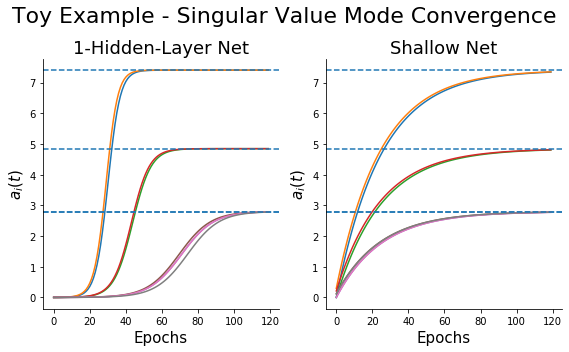

In [59]:
s_vals_deep_ana, s_vals_deep_emp = train_1hidden_net(num_hiddens, dt, num_epochs, tau(l_rate=0.05), a_0, init_var=0.01)
s_vals_shallow_ana, s_vals_shallow_emp = train_shallow_net(dt, num_epochs, tau(l_rate=0.1), a_0, init_var=0.01)
plot_figure3(s_vals_deep_ana, s_vals_deep_emp, s_vals_shallow_ana, s_vals_shallow_emp, s)

# Generating more artificial data - Branching Diffusion Process

In [9]:
class DiffuseTreeSampler():
    def __init__(self, num_features, tree_depth, branching_factor, sample_epsilon):
        self.num_features = num_features
        self.num_examples = branching_factor**tree_depth
        self.tree_depth = tree_depth
        self.branching_factor = branching_factor
        self.sample_epsilon = sample_epsilon
    
    def sample_feature(self):
        samples_per_tree_layer = [self.branching_factor**i for i in range(1, self.tree_depth+1)] 
        feature_tree = [np.random.choice([-1, 1], p=[0.5, 0.5], size=1)]
        for l in range(self.tree_depth):
            switch = np.random.choice([-1, 1],
                                      p=[self.sample_epsilon, 1-self.sample_epsilon],
                                      size=samples_per_tree_layer[l])
            next_layer = np.repeat(feature_tree[-1], self.branching_factor)
            feature_tree.append(next_layer*switch)
        return feature_tree[-1]
    
    def sample_data(self):
        """
        Each feature diffuses independently of the others!
        Sample them in sequence - but could parallelize - don't bother for now
        """
        features = []
        for feat in range(self.num_features):
            feature_temp = self.sample_feature()
            features.append(feature_temp)
        
        features_out = np.array(features).T
        items_out = np.diag(np.ones(self.num_examples))
        return features_out, items_out

In [10]:
hierarchical_tree = DiffuseTreeSampler(num_features=100, tree_depth=3,
                                       branching_factor=4, sample_epsilon=0.5)
features, items = hierarchical_tree.sample_data()

print("Output Dimensions: {}".format(features.shape))
print("Input Dimensions: {}".format(items.shape))

Output Dimensions: (64, 100)
Input Dimensions: (64, 64)


# Deeper Networks with Automatic Differentiation (PyTorch)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict

Define the variable depth Deep Linear Network architecture with & without different non-linearities/activation /transfer functions. 

In [12]:
class DeepLinearNet(nn.Module):
    """
    Class for a variable sized Linear Network
    Inputs: Input Array Dimensions, Output Array Dimensions, List of Hidden Units for all Layers
    """
    def __init__(self, input_dim, output_dim, hidden_units=[], non_lin=None):
        super(DeepLinearNet, self).__init__()
        self.num_hidden_layers = len(hidden_units)
        layers = OrderedDict()
        
        # If list of hidden units is greater than one - loop to define linear layers
        if self.num_hidden_layers > 0:
            # Define Input Layer
            layers["0"] = nn.Linear(input_dim, hidden_units[0], bias=False)
            if non_lin == "ReLU":
                layers["0-act"] = nn.ReLU()
            elif non_lin == "Sigmoid":
                layers["0-act"] = nn.Sigmoid()
            elif non_lin == "Tanh":
                layers["0-act"] = nn.Tanh()
            # Define Hidden Layers in Loop
            for l in range(1, self.num_hidden_layers):
                layers[str(l)] = nn.Linear(hidden_units[l-1], hidden_units[l], bias=False)
                if non_lin == "ReLU":
                    layers[str(l) + "-act"] = nn.ReLU()
                elif non_lin == "Sigmoid":
                    layers[str(l) + "-act"] = nn.Sigmoid()
                elif non_lin == "Tanh":
                    layers[str(l) + "-act"] = nn.Tanh()
        # Otherwise define the shallow network
        else:
            hidden_units = [input_dim]
        # Define Output Layer
        layers[str(self.num_hidden_layers)] = nn.Linear(hidden_units[-1], output_dim, bias=False)
        self.model = nn.Sequential(layers)
        
    def forward(self, input_array):
        # Propagate the input through the linear network
        return self.model(input_array.float())

In [13]:
# Define the Online Gradient Descent Training Loop
def linear_net_learning(deep_net, mse_loss, optimizer, num_epochs, train_items, train_features):
    loss_log = []
    log_singular_vals = []
    num_points = train_items.shape[0]

    for epoch in range(num_epochs):
        epoch_loss = 0
        ids = np.arange(num_points)
        np.random.shuffle(ids)
        train_items = train_items[ids]
        train_features = train_features[ids]
        
        # Loop over all examples in an Online SGD Loop
        for t in range(num_points):
            input_tensor = torch.tensor(train_items[t])
            y_true = torch.tensor(train_features[t]).float()
            y_hat = deep_net(input_tensor)
            loss = mse_loss(y_hat, y_true)
            deep_net.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        # Log the loss & the from the predictions resulting singular values
        loss_log.append(epoch_loss/num_points)
        y_hat_full = deep_net(torch.tensor(train_items)).detach().numpy()
        U, s, V = svd(y_hat_full.T, full_matrices=True)
        log_singular_vals.append(s)
    return loss_log, np.array(log_singular_vals)

In [19]:
"""
Setup the Linear Network Training
    - Generate the toy dataset
    - Compute the "true" underlying SVD
    - Initialize a network, optimizer, MSE loss
"""
hierarchical_tree = DiffuseTreeSampler(num_features=100, tree_depth=3,
                                       branching_factor=3, sample_epsilon=0.5)
features, items = hierarchical_tree.sample_data()
input_dim, output_dim = items.shape[1], features.shape[1]

SIGMA_YX = features.T @ items
U, s, V = svd(SIGMA_YX, full_matrices=True)

DeepLinearNet(
  (model): Sequential(
    (0): Linear(in_features=27, out_features=64, bias=False)
    (1): Linear(in_features=64, out_features=128, bias=False)
    (2): Linear(in_features=128, out_features=128, bias=False)
    (3): Linear(in_features=128, out_features=100, bias=False)
  )
)
DeepLinearNet(
  (model): Sequential(
    (0): Linear(in_features=27, out_features=64, bias=False)
    (0-act): ReLU()
    (1): Linear(in_features=64, out_features=128, bias=False)
    (1-act): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=False)
    (2-act): ReLU()
    (3): Linear(in_features=128, out_features=100, bias=False)
  )
)


In [35]:
l_rate = 0.5

shallow_lin_net = DeepLinearNet(input_dim, output_dim)
shallow_optimizer = optim.SGD(shallow_lin_net.parameters(), lr=l_rate)

deep_lin_net = DeepLinearNet(input_dim, output_dim, [64, 128, 128])
lin_optimizer = optim.SGD(deep_lin_net.parameters(), lr=l_rate)

deep_relu_net = DeepLinearNet(input_dim, output_dim, [64, 128, 128], non_lin="ReLU")
relu_optimizer = optim.SGD(deep_relu_net.parameters(), lr=l_rate)

mse_loss = nn.MSELoss()

print(deep_lin_net)
print(deep_relu_net)

DeepLinearNet(
  (model): Sequential(
    (0): Linear(in_features=27, out_features=64, bias=False)
    (1): Linear(in_features=64, out_features=128, bias=False)
    (2): Linear(in_features=128, out_features=128, bias=False)
    (3): Linear(in_features=128, out_features=100, bias=False)
  )
)
DeepLinearNet(
  (model): Sequential(
    (0): Linear(in_features=27, out_features=64, bias=False)
    (0-act): ReLU()
    (1): Linear(in_features=64, out_features=128, bias=False)
    (1-act): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=False)
    (2-act): ReLU()
    (3): Linear(in_features=128, out_features=100, bias=False)
  )
)


## Non-Linear Networks - Comparing Shallow, Linear & ReLU Architectures

In [36]:
# Run the learning loops (shallow/linear/ReLU)
num_epochs = 1000
loss_log_shallow, log_s_vals_shallow = linear_net_learning(shallow_lin_net, mse_loss, shallow_optimizer, num_epochs, items, features)
loss_log_linear, log_s_vals_linear = linear_net_learning(deep_lin_net, mse_loss, lin_optimizer, 200, items, features)
loss_log_relu, log_s_vals_relu = linear_net_learning(deep_relu_net, mse_loss, relu_optimizer, 200, items, features)

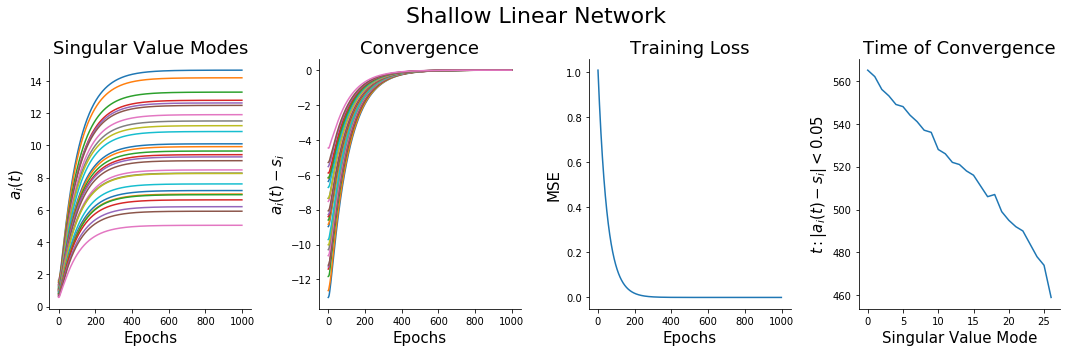

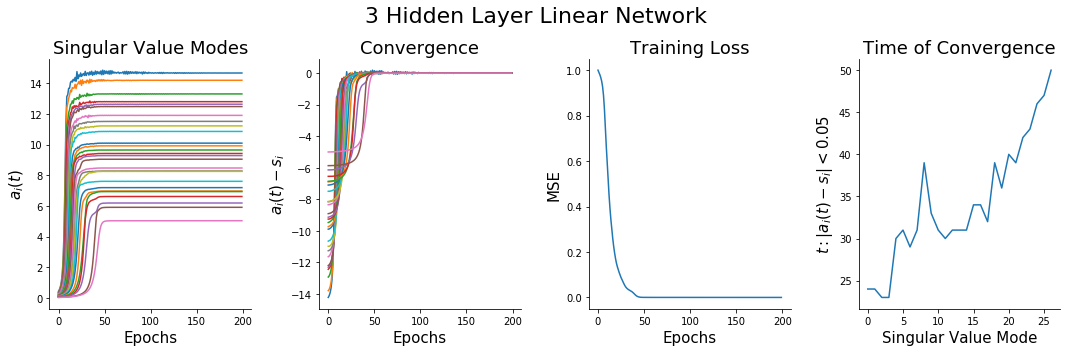

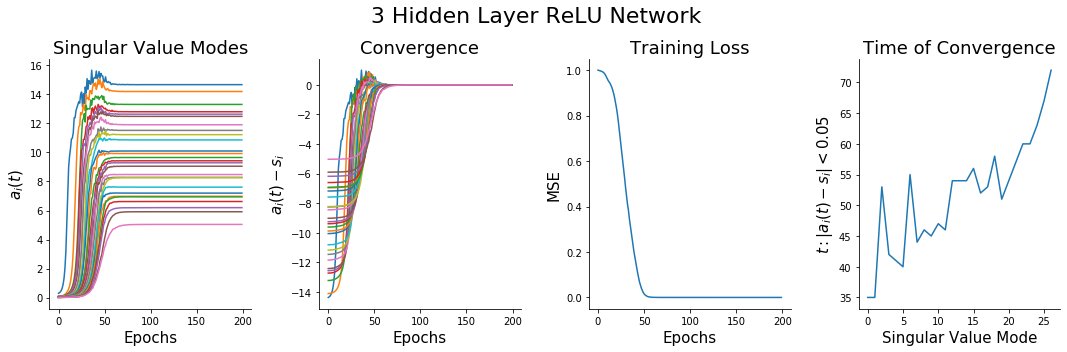

In [37]:
#Plot the results - Shallow/Linear/ReLU Network 
axs_shallow = plot_singular_val_dynamics(log_s_vals_shallow, loss_log_shallow, s, title='Shallow Linear Network')
axs_linear = plot_singular_val_dynamics(log_s_vals_linear, loss_log_linear, s, title='3 Hidden Layer Linear Network')
axs_relu = plot_singular_val_dynamics(log_s_vals_relu, loss_log_relu, s, title='3 Hidden Layer ReLU Network')

## Optimization Algorithm - Comparing SGD, Adam & RMSprop

In [44]:
# Define the networks & Optimizer
deep_lin_sgd = DeepLinearNet(input_dim, output_dim, [64, 128, 128])
sgd_optimizer = optim.SGD(deep_lin_sgd.parameters(), lr=0.1)

deep_lin_adam = DeepLinearNet(input_dim, output_dim, [64, 128, 128])
adam_optimizer = optim.Adam(deep_lin_adam.parameters(), lr=0.001)

deep_lin_rms = DeepLinearNet(input_dim, output_dim, [64, 128, 128])
rmsprop_optimizer = optim.RMSprop(deep_lin_rms.parameters(), lr=0.001)

In [45]:
# Run the learning loops (SGD/Adam/RMSprop)
num_epochs = 500
loss_log_sgd, log_s_vals_sgd = linear_net_learning(deep_lin_sgd, mse_loss, sgd_optimizer, num_epochs, items, features)
loss_log_adam, log_s_vals_adam = linear_net_learning(deep_lin_adam, mse_loss, adam_optimizer, num_epochs, items, features)
loss_log_rms, log_s_vals_rms = linear_net_learning(deep_lin_rms, mse_loss, rmsprop_optimizer, num_epochs, items, features)

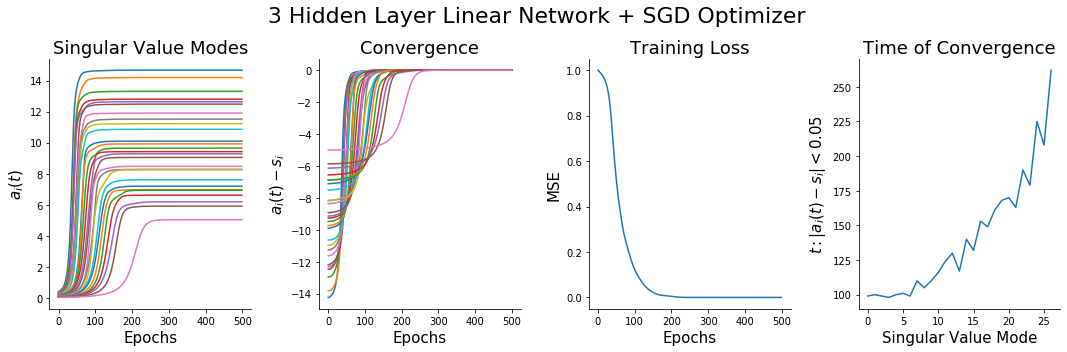

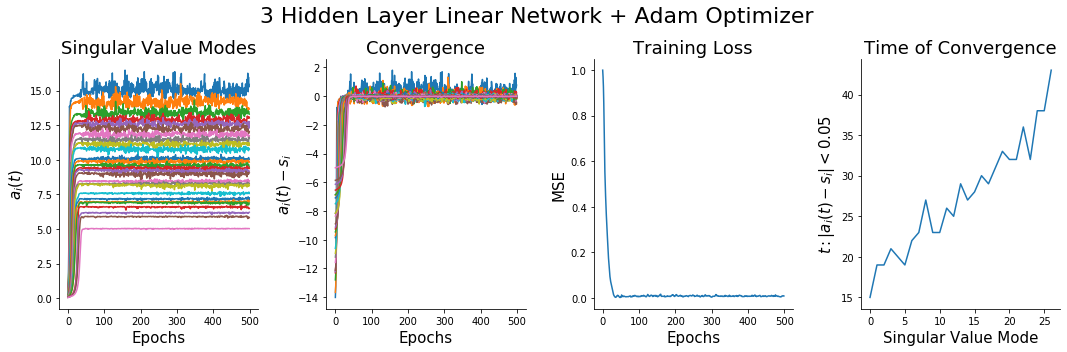

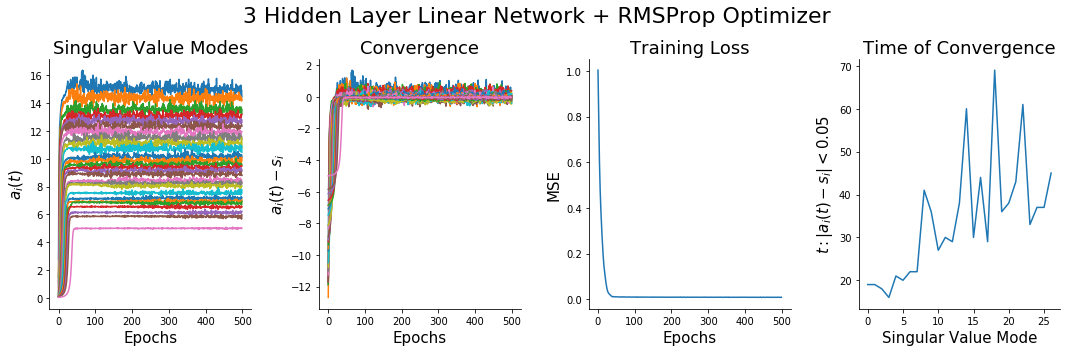

In [46]:
#Plot the results - Linear Network with SGD/Adam/RMSProp
axs_sgd = plot_singular_val_dynamics(log_s_vals_sgd, loss_log_sgd, s, title='3 Hidden Layer Linear Network + SGD Optimizer')
axs_adam = plot_singular_val_dynamics(log_s_vals_adam, loss_log_adam, s, title='3 Hidden Layer Linear Network + Adam Optimizer')
axs_rms = plot_singular_val_dynamics(log_s_vals_rms, loss_log_rms, s, title='3 Hidden Layer Linear Network + RMSProp Optimizer')

# Singular Value Convergence & Overfitting

In [ ]:
import pandas as pd
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
train.shape

In [ ]:
def train_wrt_singular(deep_net, mse_loss, optimizer, num_epochs, items, features,
                       train_test_prob=0.8):
    loss_log_train, loss_log_test = [], []
    log_singular_vals = []
    num_points = train_items.shape[0]
    
    # Split the data into train & test data
    items_train, items_test, features_train, features_test = train_test_split(items, features,
                                                                              test_size=train_test_prob,
                                                                              random_state=42)
    
    for epoch in range(num_epochs):
        # Init Loss & shuffle the data
        epoch_loss_train = 0
        ids = np.arange(num_points)
        np.random.shuffle(ids)
        items_train = items_train[ids]
        features_train = features_train[ids]
        
        # Loop over all examples in an Online SGD Loop
        for t in range(num_points):
            input_tensor = torch.tensor(items_train[t])
            y_true = torch.tensor(features_train[t]).float()
            y_hat = deep_net(input_tensor)
            train_loss = mse_loss(y_hat, y_true)
            deep_net.zero_grad()
            train_loss.backward()
            optimizer.step()
            epoch_loss += train_loss.item()
        
        input_tensor = torch.tensor(train_items) 
        # Log the loss & the from the predictions resulting singular values
        loss_log.append(epoch_loss/num_points)
        y_hat_full = deep_net(torch.tensor(train_items)).detach().numpy()
        U, s, V = svd(y_hat_full.T, full_matrices=True)
        log_singular_vals.append(s)
    return loss_log, np.array(log_singular_vals)

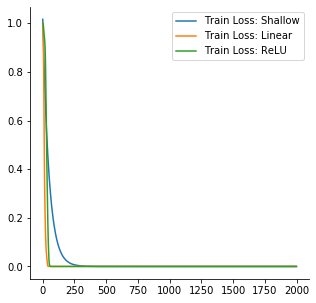

In [23]:
train_losses = [loss_log_shallow, loss_log_linear, loss_log_relu]
plot_learning_loss(train_losses, test_losses=None, legend_titles=["Shallow", "Linear", "ReLU"])

# Regularizing Deep Networks with Singular Values

In [60]:
def mse_singular_loss(output, target, s, reg_hyperp):
    mse_loss = torch.mean((output - target)**2)
    
    torch.svd(target)
    return loss